### Intro to Neural ODEs in Julia (with NeuralPDEs.jl)
---

Let's first try to solve:
$$ u'(t) = \cos(2 \pi t); \quad u(0)=0 $$
on the domain $t \in [0, 1]$

In [34]:
using NeuralPDE

In [35]:
# first, define the ODE in the format of DifferentialEquations.jl
linear(u, p, t) = cos(t * 2 * pi)
tspan = (0.0, 1.0)
u0 = 0.0
prob = ODEProblem(linear, u0, tspan);

Now, to define the NNODE solver, we must choose a neural network architecture. To do this, we will use the Lux.jl to define a multilayer perceptron (MLP) with one hidden layer of 5 nodes and a sigmoid activation function. This looks like:

In [36]:
using Lux, Random

In [37]:
rng = Random.default_rng()
Random.seed!(rng, 0)
# our NN will be a dense network of 1 object going to a hidden layer of 5 nodes with sigmoid (σ) activation
# the next argument means it has to go from the 5 nodes to 1 output object
chain = Chain(Dense(1, 5, σ), Dense(5, 1))

# then the parameters (the p's, or the "ps" here) and our state (st) will be random at first and Float64s. 
ps, st = Lux.setup(rng, chain) |> Lux.f64

((layer_1 = (weight = [-0.04929668828845024; -0.3266667425632477; … ; -1.4946011304855347; -1.0391809940338135;;], bias = [-0.458548903465271, -0.8280583620071411, -0.38509929180145264, 0.32322537899017334, -0.32623517513275146]), layer_2 = (weight = [0.5656673908233643 -0.605137288570404 … 0.3129439055919647 0.22128699719905853], bias = [-0.11007555574178696])), (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

Now we must choose an optimizer to define the NNODE solver. A common choice is Adam, with a tunable learning rate, which we will set to $0.1$.

In general, this learning rate parameter should be decreased if the solver's loss tends to be unsteady (sometimes rise “too much”), but should be as large as possible for efficiency.

In [38]:
using OptimizationOptimisers

opt = Adam(0.1)
alg = NNODE(chain, opt, init_params = ps)

NNODE{Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Adam, Nothing, Bool, Nothing, Bool, Nothing, Base.Pairs{Symbol, @NamedTuple{layer_1::@NamedTuple{weight::Matrix{Float64}, bias::Vector{Float64}}, layer_2::@NamedTuple{weight::Matrix{Float64}, bias::Vector{Float64}}}, Tuple{Symbol}, @NamedTuple{init_params::@NamedTuple{layer_1::@NamedTuple{weight::Matrix{Float64}, bias::Vector{Float64}}, layer_2::@NamedTuple{weight::Matrix{Float64}, bias::Vector{Float64}}}}}}(Chain{@NamedTuple{layer_1::Dense{typeof(σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(1 => 5, σ), layer_2 = Dense(5 => 1)), nothing), Adam(0.1, (0.9, 0.999), 1.0e-8), nothing, false, true, nothing, false, nothing, Base.Pairs{Symbol, @NamedTuple{layer_1::@NamedTuple{weight::Matrix{Float64}, b

Once these pieces are together, we call solve just like with any other ODEProblem. Let's turn on verbose so we can see the loss over time during the training process:

In [39]:
sol = solve(prob, alg, verbose = true, maxiters = 2000, saveat = 0.01)

[NNODE]	Iter: [   1/2000]	Loss: 0.396517
[NNODE]	Iter: [   2/2000]	Loss: 0.844463
[NNODE]	Iter: [   3/2000]	Loss: 0.408456
[NNODE]	Iter: [   4/2000]	Loss: 0.456775
[NNODE]	Iter: [   5/2000]	Loss: 0.612152
[NNODE]	Iter: [   6/2000]	Loss: 0.505999
[NNODE]	Iter: [   7/2000]	Loss: 0.373982
[NNODE]	Iter: [   8/2000]	Loss: 0.371726
[NNODE]	Iter: [   9/2000]	Loss: 0.446597
[NNODE]	Iter: [  10/2000]	Loss: 0.473306
[NNODE]	Iter: [  11/2000]	Loss: 0.422985
[NNODE]	Iter: [  12/2000]	Loss: 0.359954
[NNODE]	Iter: [  13/2000]	Loss: 0.343271
[NNODE]	Iter: [  14/2000]	Loss: 0.372845
[NNODE]	Iter: [  15/2000]	Loss: 0.400685
[NNODE]	Iter: [  16/2000]	Loss: 0.390428
[NNODE]	Iter: [  17/2000]	Loss: 0.35502
[NNODE]	Iter: [  18/2000]	Loss: 0.330056
[NNODE]	Iter: [  19/2000]	Loss: 0.332764
[NNODE]	Iter: [  20/2000]	Loss: 0.350223
[NNODE]	Iter: [  21/2000]	Loss: 0.357866
[NNODE]	Iter: [  22/2000]	Loss: 0.345807
[NNODE]	Iter: [  23/2000]	Loss: 0.325536
[NNODE]	Iter: [  24/2000]	Loss: 0.314416
[NNODE]	Iter: [  

retcode: Success
Interpolation: Trained neural network interpolation
t: 0.0:0.01:1.0
u: 101-element Vector{Float64}:
  0.0
  0.011122148960847192
  0.021903577862844265
  0.03233486390097657
  0.04240640468441208
  0.052108417791172784
  0.06143094321509865
  0.07036384930263863
  0.07889684281532472
  0.0870194837848687
  0.09472120584945434
  0.10199134276958048
  0.10881916181719621
  ⋮
 -0.10001946822408135
 -0.09264170374509643
 -0.08483882869155374
 -0.07662628480687854
 -0.06801982564056938
 -0.059035451649162275
 -0.049689347965375136
 -0.03999782490344145
 -0.02997726125989818
 -0.019644050460511656
 -0.009014549595332317
  0.0018949686250016766

let's now solve our actual ODE for comparison

In [40]:
using OrdinaryDiffEq
ground_truth = solve(prob, Tsit5(), saveat = 0.01);

In [41]:
using Plots

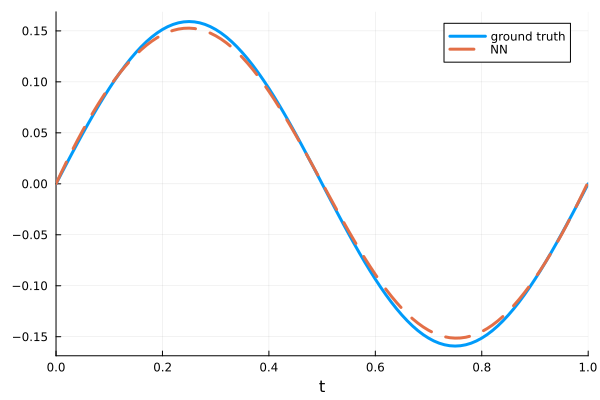

In [42]:
plot(ground_truth, lw=3, label = "ground truth")
plot!(sol.t, sol.u, line=(3, :dash), label = "NN")